<a href="https://colab.research.google.com/github/Pravallika-02-datascience/Unsupervised-Machine-Learning-Algorithm/blob/main/Logistic_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------------------------------------------------------------
# Logistic‑Regression • Titanic Survival  (fixed: no Survived in external test)
# ---------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    confusion_matrix
)
import joblib

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


Train shape: (891, 12)    Test shape: (418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      

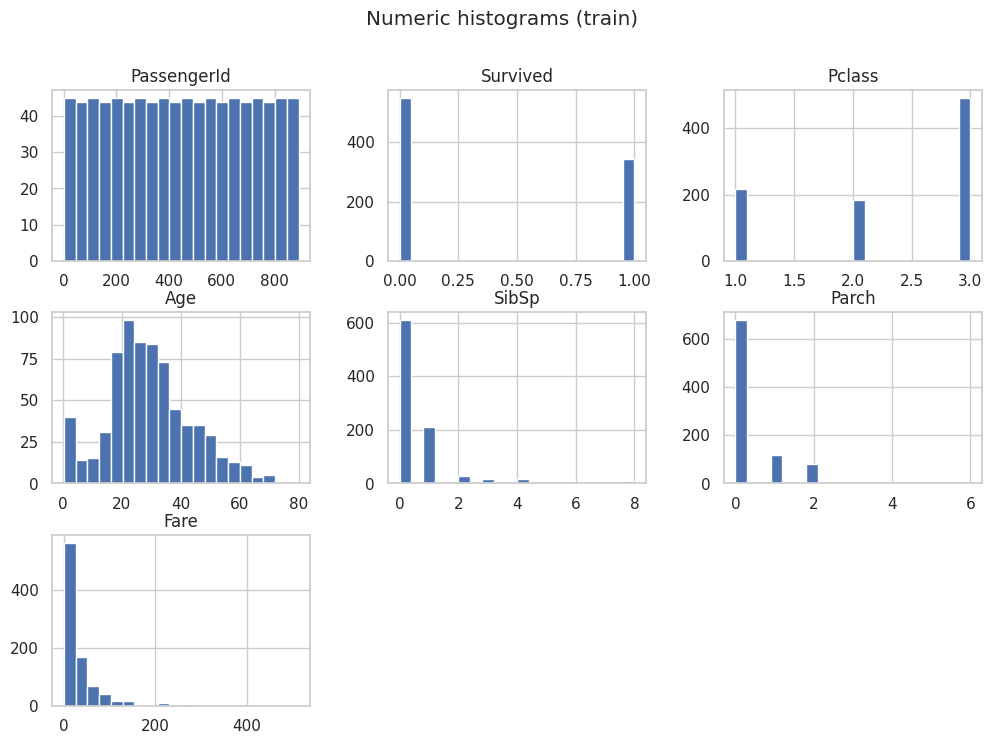

In [ ]:
# ------------------------------------------------------------------
# 1. LOAD DATA  & QUICK EDA
# ------------------------------------------------------------------
train_df = pd.read_csv("Titanic_train.csv")
test_df  = pd.read_csv("Titanic_test.csv")      # ← no Survived column

print("Train shape:", train_df.shape, "   Test shape:", test_df.shape)
print(train_df.head())

# Basic numeric histograms
train_df.select_dtypes(include=["int64","float64"]).hist(bins=20, figsize=(12, 8))
plt.suptitle("Numeric histograms (train)"); plt.show()

In [ ]:
# ------------------------------------------------------------------
# 2. PREPROCESSING DEFINITION
# ------------------------------------------------------------------
target = "Survived"

X = train_df.drop(columns=[target])
y = train_df[target]

num_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])

In [ ]:
# ------------------------------------------------------------------
# 3. TRAIN / VALID SPLIT  &  MODEL BUILD
# ------------------------------------------------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = Pipeline([
    ("prep", preprocess),
    ("logreg", LogisticRegression(max_iter=1000, solver="liblinear"))
])
model.fit(X_train, y_train)
print("✔ Model trained.")

✔ Model trained.



Validation metrics
Accuracy : 0.827
Precision: 0.806
Recall   : 0.725
F1‑score : 0.763
ROC‑AUC  : 0.853


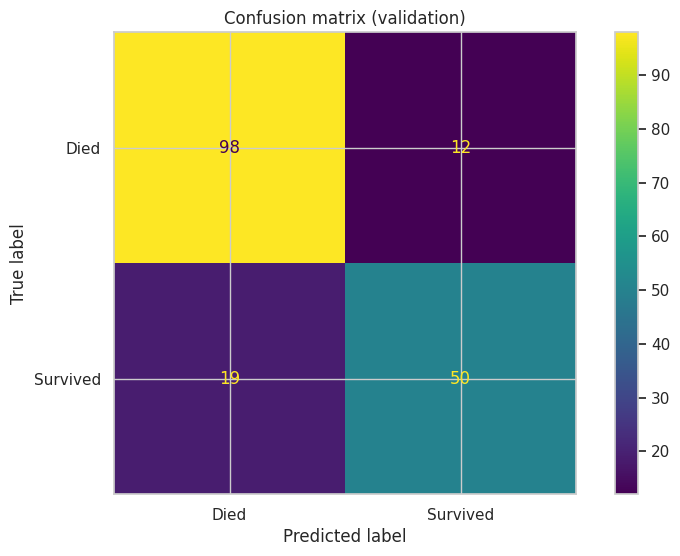

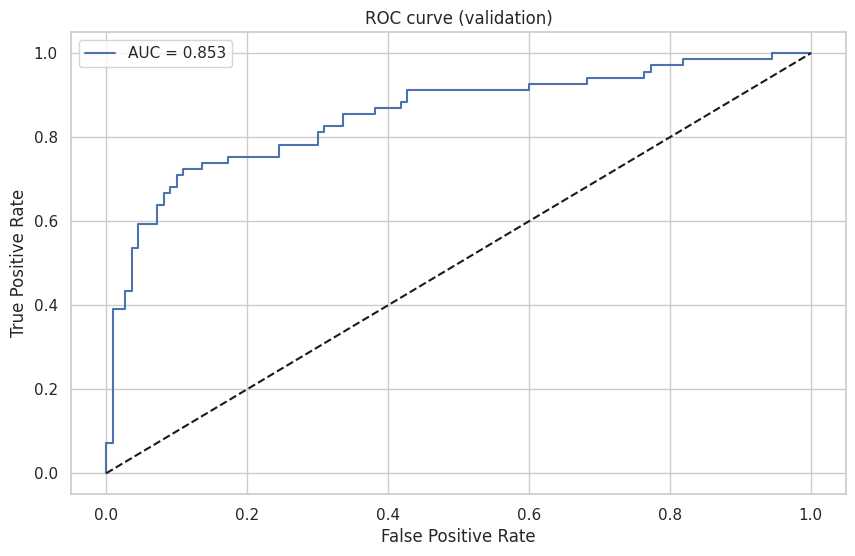

In [ ]:
# ------------------------------------------------------------------
# 4. MODEL EVALUATION ON VALIDATION SET
# ------------------------------------------------------------------
y_pred     = model.predict(X_valid)
y_pred_pro = model.predict_proba(X_valid)[:,1]

acc  = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec  = recall_score(y_valid, y_pred)
f1   = f1_score(y_valid, y_pred)
auc  = roc_auc_score(y_valid, y_pred_pro)

print(f"\nValidation metrics")
print(f"Accuracy : {acc:0.3f}")
print(f"Precision: {prec:0.3f}")
print(f"Recall   : {rec:0.3f}")
print(f"F1‑score : {f1:0.3f}")
print(f"ROC‑AUC  : {auc:0.3f}")

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred),
                       display_labels=["Died","Survived"]).plot()
plt.title("Confusion matrix (validation)"); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_pro)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:0.3f}")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curve (validation)"); plt.legend(); plt.show()


In [ ]:
# ------------------------------------------------------------------
# 5. COEFFICIENT INTERPRETATION
# ------------------------------------------------------------------
oh_cols = model.named_steps["prep"].named_transformers_["cat"]\
             .named_steps["onehot"].get_feature_names_out(cat_features)
all_features = num_features + oh_cols.tolist()
coefs = model.named_steps["logreg"].coef_[0]

coef_df = (pd.DataFrame({"feature":all_features,
                         "coef":coefs})
             .sort_values("coef", ascending=False))

print("\nTop positive coefficients (higher survival chance):")
print(coef_df.head())

print("\nTop negative coefficients (lower survival chance):")
print(coef_df.tail())



Top positive coefficients (higher survival chance):
            feature      coef
786     Ticket_1601  2.030967
718      Sex_female  1.589312
1000  Ticket_347077  1.046806
924    Ticket_29106  0.893192
1089  Ticket_367226  0.849843

Top negative coefficients (lower survival chance):
            feature      coef
895     Ticket_2678 -0.850647
1416       Cabin_G6 -0.934227
1054  Ticket_349909 -0.941130
1003  Ticket_347082 -0.995097
719        Sex_male -1.218969


In [ ]:
# ------------------------------------------------------------------
# 6. PREDICTIONS FOR UNLABELED TEST SET & SAVE MODEL
# ------------------------------------------------------------------
test_probs = model.predict_proba(test_df)[:,1]
test_preds = (test_probs >= 0.5).astype(int)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived":    test_preds,
    "Survival_Prob": test_probs
})
submission.to_csv("titanic_test_predictions.csv", index=False)
print("\n📝 Predictions saved to titanic_test_predictions.csv")

joblib.dump(model, "titanic_logreg.pkl")
print("🔒 Trained model saved to titanic_logreg.pkl")



📝 Predictions saved to titanic_test_predictions.csv
🔒 Trained model saved to titanic_logreg.pkl
